Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Max length: 63500
63500
63500
63500
63500
63500
63500
63500
63500
63500
63500
Trying parameters: {'hidden_size': 50, 'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 5}
Trying parameters: {'hidden_size': 50, 'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 10}
Trying parameters: {'hidden_size': 50, 'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 15}
Trying parameters: {'hidden_size': 50, 'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 5}
Trying parameters: {'hidden_s

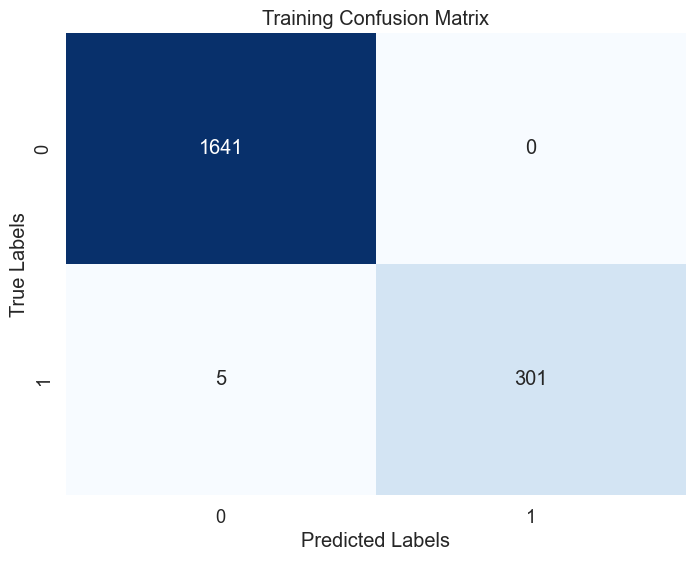

Training Confusion Matrix:
[[1641    0]
 [   5  301]]
Number of images in the validation set: 420


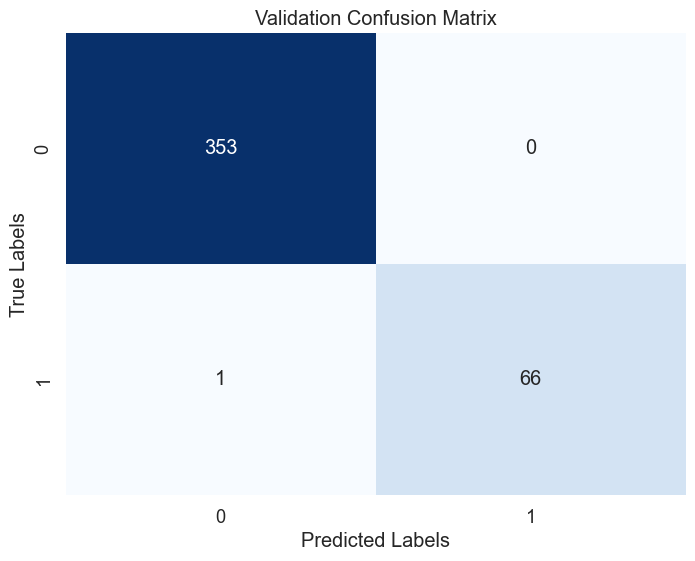

Validation Confusion Matrix:
[[353   0]
 [  1  66]]
Number of images in the test dataset: 417


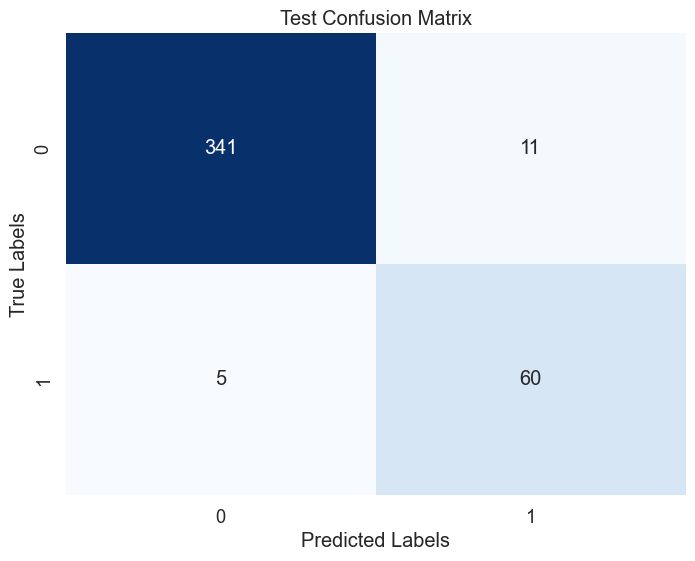

Test Confusion Matrix:
[[341  11]
 [  5  60]]
Test Metrics:
Accuracy: 0.9616306954436451
Precision: 0.8450704225352113
Recall: 0.9230769230769231
F1 Score: 0.8823529411764706


In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Constants
torch.manual_seed(42)
np.random.seed(42)

img_size = 250
num_classes = 2
class_folders = ['polyp', 'uterus']

# Dataset definition
class PolypDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    
    # Check if the image loaded successfully
    if img is None:
        return None
    
    # Bilateral Filtering for Image Denoising
    img = cv2.bilateralFilter(img, 9, 75, 75)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    img = cv2.resize(thresh, (img_size, img_size))  
    return img

def calculate_lbp_features(img):
    lbp_radius = 3
    lbp_points = 8 * lbp_radius
    lbp = local_binary_pattern(img, lbp_points, lbp_radius, method='uniform')
    return lbp.flatten()

def extract_sift_features(img):
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(img, None)  # use img directly as it's already grayscale
    if descriptors is None:
        descriptors = np.zeros((1, 128))
    
    # Flatten and ensure the descriptor is of length 1000
    descriptors_flat = descriptors.flatten()
    
    # Check the length of descriptors_flat before padding or truncating
    if len(descriptors_flat) >= 1000:
        padded_descriptors = descriptors_flat[:1000]
    else:
        padded_descriptors = np.pad(descriptors_flat, (0, 1000 - len(descriptors_flat)), mode='constant')
    
    return padded_descriptors


# Load images and extract features
def load_data_from_folder(folder):
    data = []
    labels = []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']  # Define the valid extensions here
    for i, class_folder in enumerate(class_folders):
        class_path = os.path.join(folder, class_folder)
        for image_name in os.listdir(class_path):
            if any(image_name.lower().endswith(ext) for ext in valid_extensions):  # Check the file extension
                image_path = os.path.join(class_path, image_name)
                img = preprocess_image(image_path)
                if img is None:
                    continue
                lbp_features = calculate_lbp_features(img)
                sift_features = extract_sift_features(img)
                features = np.concatenate((lbp_features, sift_features))
                data.append(features)
                labels.append(i)
    return data, labels

# New Path: "/Users/ummefahmidaakter/Desktop/Completed Assessments/Dissertation/dissertation_project/up4"
# If any error occurs while running this code, it mostly could be bacause of incorrect root path

train_data, train_labels = load_data_from_folder("/Users/ummefahmidaakter/Downloads/up4/train")
val_data, val_labels = load_data_from_folder("/Users/ummefahmidaakter/Downloads/up4/val")

data = train_data + val_data
max_len = max([len(d) for d in data])
print(f"Max length: {max_len}")
for i, d in enumerate(data):
    if len(d) != max_len:
        print(f"Data at index {i} has length {len(d)}")

scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)

for i in range(10):  # print the length of the first 10 feature vectors
    print(len(train_data[i]))

# Hyperparameters
param_grid = {
    'hidden_size': [50, 100, 200],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [5, 10, 15]
}

best_accuracy = 0.0
best_params = {}
best_metrics = {}

# Grid search
for params in itertools.product(*param_grid.values()):
    current_params = dict(zip(param_grid.keys(), params))
    
    print(f"Trying parameters: {current_params}")

    torch.manual_seed(42)
    np.random.seed(42)

    train_dataset = PolypDataset(train_data, train_labels)
    val_dataset = PolypDataset(val_data, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=current_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=current_params['batch_size'], shuffle=False)

    model = FCNN(input_size=train_data.shape[1], hidden_size=current_params['hidden_size'], num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=current_params['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(current_params['num_epochs']):
        # Train
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_predictions = []
        val_true = []

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images.float())
                _, predicted = torch.max(outputs.data, 1)
                val_predictions.extend(predicted.tolist())
                val_true.extend(labels.tolist())

        accuracy = accuracy_score(val_true, val_predictions)
        precision = precision_score(val_true, val_predictions, zero_division=0)
        recall = recall_score(val_true, val_predictions, zero_division=0)
        f1 = f1_score(val_true, val_predictions, zero_division=0)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = current_params
            best_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1
            }

print('Best Parameters:', best_params)
print('Best Metrics:', best_metrics)

# Using the best model parameters, now train on combined train + val and test on test set

combined_data = np.concatenate((train_data, val_data))
combined_labels = train_labels + val_labels

test_data, test_labels = load_data_from_folder("/Users/ummefahmidaakter/Downloads/up4/test")
test_data = scaler.transform(test_data)

# Train the model using best_params on combined data
combined_dataset = PolypDataset(combined_data, combined_labels)
combined_loader = DataLoader(combined_dataset, batch_size=best_params['batch_size'], shuffle=True)

model = FCNN(input_size=combined_data.shape[1], hidden_size=best_params['hidden_size'], num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

for epoch in range(best_params['num_epochs']):
    model.train()
    for images, labels in combined_loader:
        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model on the training set using only training data loader
model.eval()
train_predictions = []
train_true = []

train_dataset = PolypDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=False)

with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        train_predictions.extend(predicted.tolist())
        train_true.extend(labels.tolist())

train_confusion_matrix = confusion_matrix(train_true, train_predictions)

# Before displaying the training confusion matrix
print(f"Number of images in the training set: {len(train_data)}")

# Display the training confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()

print('Training Confusion Matrix:')
print(train_confusion_matrix)

# Evaluate the model on the validation set
model.eval()
val_predictions = []
val_true = []

val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.tolist())
        val_true.extend(labels.tolist())

val_confusion_matrix = confusion_matrix(val_true, val_predictions)

# Before displaying the validation confusion matrix
print(f"Number of images in the validation set: {len(val_data)}")

# Display the validation confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(val_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()

print('Validation Confusion Matrix:')
print(val_confusion_matrix)

# Evaluate the model on the test set
model.eval()
test_predictions = []
test_true = []

test_dataset = PolypDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.tolist())
        test_true.extend(labels.tolist())
        
test_confusion_matrix = confusion_matrix(test_true, test_predictions)

# Before displaying the validation confusion matrix
print(f"Number of images in the test dataset: {len(test_data)}")

# Display the test confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')
plt.show()

print('Test Confusion Matrix:')
print(test_confusion_matrix)

test_accuracy = accuracy_score(test_true, test_predictions)
test_precision = precision_score(test_true, test_predictions, zero_division=0)
test_recall = recall_score(test_true, test_predictions, zero_division=0)
test_f1 = f1_score(test_true, test_predictions, zero_division=0)

print('Test Metrics:')
print('Accuracy:', test_accuracy)
print('Precision:', test_precision)
print('Recall:', test_recall)
print('F1 Score:', test_f1)

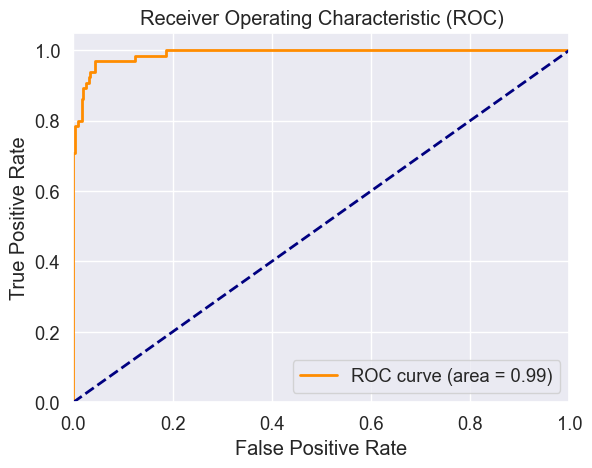

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
softmax = nn.Softmax(dim=1)
test_probabilities = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.float())
        probs = softmax(outputs)[:, 1].tolist()  # Probabilities for positive class
        test_probabilities.extend(probs)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_true, test_probabilities)
roc_auc = roc_auc_score(test_true, test_probabilities)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()